# Intelligence Report: Exploratory Data Analysis (Active Environment)
**Project:** Orbital Clutter: Mapping the Kessler Acceleration  
**Dataset:** `ucs_cleaned.csv` (Active Satellite Population)  
**Analyst:** James Glosser  

---

### **The Analytical Strategy**
Before modeling the collision probability of the debris field, we must establish a baseline of the **Active Population**. This notebook characterizes the "Target Environment" across three dimensions:

1.  **Mass Profiling:** Identifying "High-Value" targets versus the swarm (Starlink/CubeSats) to understand kinetic potential.
2.  **Stakeholder Analysis:** Quantifying the shift from State-Actor dominance to Commercial proliferation.
3.  **Temporal Dynamics:** Modeling the velocity of "New Space" launches to determine the acceleration rate.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit, brentq

# Visual Architecture: Orbital Dashboard ---
# Set the Palette (High Contrast Neon)
sns.set_palette("plasma") 

# Set the Background (Deep Space Black)
plt.style.use('dark_background')

# Force Overrides for "True Black" and readability
plt.rcParams.update({
    "grid.alpha": 0.2,            # Faint, non-intrusive grid
    "axes.facecolor": "black",    # No grey haze in plot area
    "figure.facecolor": "black",  # No grey haze in outer area
    "text.color": "white",        # High contrast text
    "axes.labelcolor": "white",   # Axis labels
    "xtick.color": "white",       # Ticks
    "ytick.color": "white",
    "legend.facecolor": "black",  # Legend background
    "legend.edgecolor": "white"   # Legend border
})

print("Environment Initialized: Visual Systems Online.")

Environment Initialized: Visual Systems Online.


In [2]:
# Load the "Deep Scrub" Dataset
# We parse dates immediately to enable the Temporal Analysis later
ucs_cleaned = pd.read_csv('../../data/clean/ucs_cleaned.csv', parse_dates=['launch_date'])

# Mission Status Check
print(f"Active Fleet Registry Synchronized: {len(ucs_cleaned)} operational assets validated.")
print(f"Data Schema: {ucs_cleaned.shape[1]} features available.")

Active Fleet Registry Synchronized: 7542 operational assets validated.
Data Schema: 34 features available.


### Data Pre-Processing: Feature Engineering
**Objective:** Standardize categorical features for aggregation.
* **Orbit Regimes:** Compressing sub-classes into the "Big Three" (`LEO`, `MEO`, `GEO`) to map the Kessler Canyon.

In [3]:
# Standardize Orbit Classes -> 'orbit_regime'
# We map the complex registry into the "Big Three" risk zones (Regimes).

# Anything that isn't LEO, MEO, or GEO gets tagged as "Other".
target_orbits = ['LEO', 'MEO', 'GEO']
ucs_cleaned['orbit_regime'] = ucs_cleaned['orbit_class'].apply(lambda x: x if x in target_orbits else 'Other')

# Integrity Check
# Verify the new 'orbit_regime' column
print(f"Features Verified: 'launch_year' is present.")
print(f"Regime Standardization: {ucs_cleaned['orbit_regime'].value_counts().to_dict()}")

Features Verified: 'launch_year' is present.
Regime Standardization: {'LEO': 6750, 'GEO': 590, 'MEO': 143, 'Other': 59}


## Section 1.0: Kinetic Mass Profiling
**The Objective:** Visualize the distribution of mass in orbit. In a collision event, mass equates to "shrapnel potential." We must distinguish between the "Swarm" (low mass, high count) and the "Heavy Hitters" (high mass, low count).

**The Methodology:**
* **Logarithmic Scaling:** Applied to `launch_mass_kg` to account for the disparity between CubeSats (<10 kg) and the **International Space Station (450,000 kg)**.
* **White Whale Logic:** Explicitly handling the ISS outlier to prevent visualization compression.

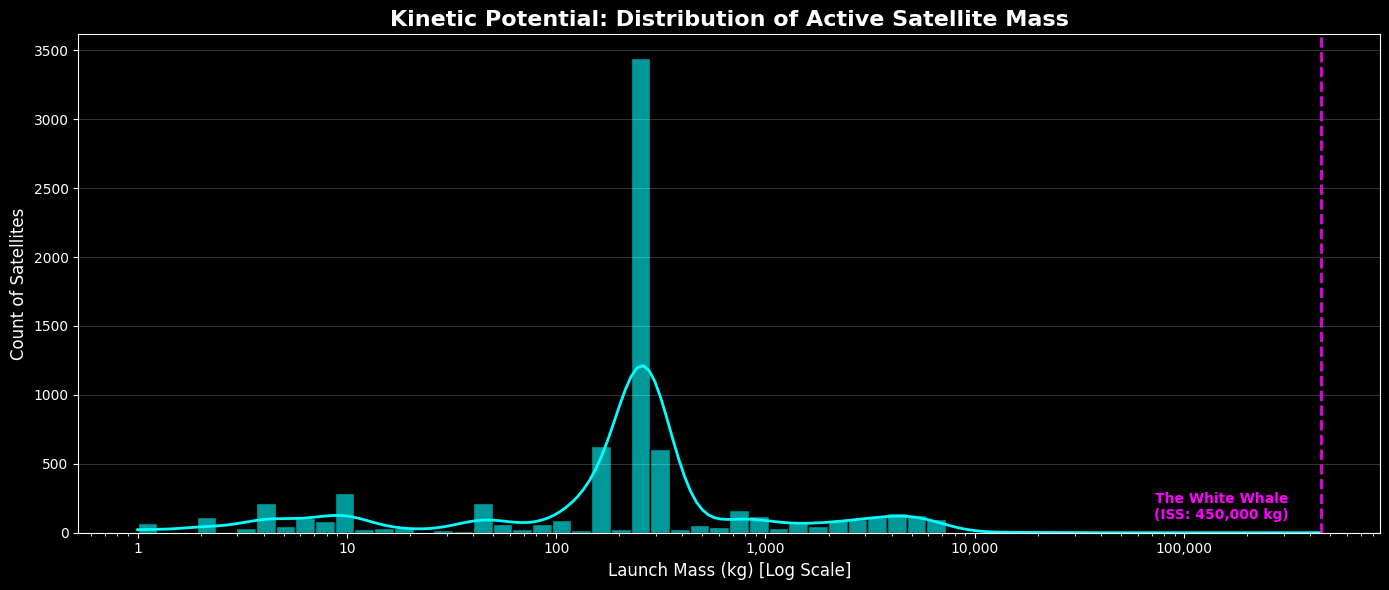

--- Mass Profile Statistics (kg) ---
count      7542.000000
mean        690.293821
std        5358.470524
min           1.000000
25%         148.000000
50%         260.000000
75%         280.000000
max      450000.000000
Name: launch_mass_kg, dtype: object


In [4]:
plt.figure(figsize=(14, 6))

# The Histogram (The Swarm vs. The Heavy Hitters)
# We use log_scale=True because the range [1kg ... 450,000kg] is extremely wide for linear plots
sns.histplot(ucs_cleaned['launch_mass_kg'], kde=True, bins=60, log_scale=True, 
             color='cyan', edgecolor='black', alpha=0.6, line_kws={'linewidth': 2})

# The "White Whale" Annotation (ISS)
# We highlight the ISS specifically because it represents the single largest collision risk
iss_mass = 450000
plt.axvline(iss_mass, color='magenta', linestyle='--', linewidth=2, alpha=0.9)
plt.text(iss_mass * 0.7, 100, f'The White Whale\n(ISS: {iss_mass:,} kg)', 
         color='magenta', ha='right', fontweight='bold')

# Formatting the Axis to be easier to read. Average people can't visualize/conceptualize what "10^5 kg (100,000 kg)" represents.

# Get current axis
ax = plt.gca()

# This function converts "10^3" -> "1,000" for instant readability
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Standard Labels (Space Theme)
plt.title('Kinetic Potential: Distribution of Active Satellite Mass', fontsize=16, color='white', fontweight='bold')
plt.xlabel('Launch Mass (kg) [Log Scale]', fontsize=12, color='white')
plt.ylabel('Count of Satellites', fontsize=12, color='white')
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

# 5. Statistical Audit
print("--- Mass Profile Statistics (kg) ---")
print(ucs_cleaned['launch_mass_kg'].describe().apply(lambda x: format(x, 'f')))

## Section 1.5: Orbital Topography (The Kessler Canyon)
**The Objective:** Map the physical distribution of assets to identify the "Kessler Canyon"—the altitude bands with the highest density of collision targets.

**The Insight:**
Mass is not evenly distributed. The **Scatter Analysis** below reveals that the "Swarm" (low mass) is concentrating in Low Earth Orbit (LEO), while legacy heavy platforms dominate Geosynchronous Orbit (GEO).

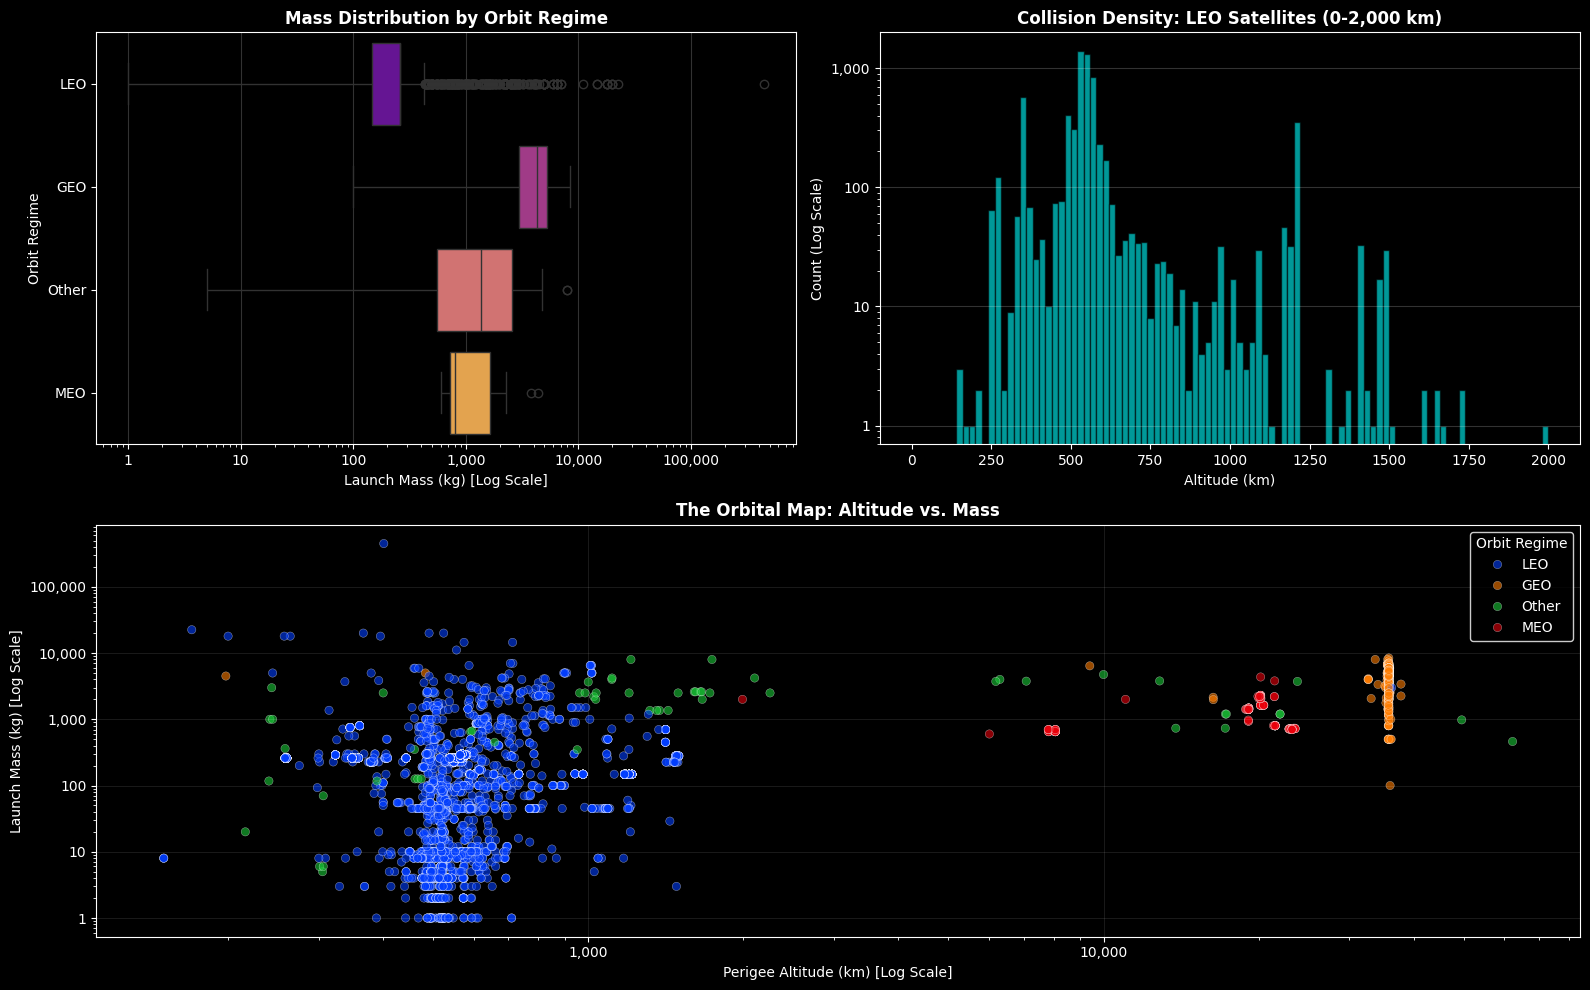

In [5]:
plt.figure(figsize=(16, 10))

# Plot A: Mass vs. Orbit Regime (The Weight of Regimes)
plt.subplot(2, 2, 1)
sns.boxplot(data=ucs_cleaned, x='launch_mass_kg', y='orbit_regime', hue='orbit_regime', palette='plasma', legend=False)
plt.xscale('log')

# Formatting the Axis to be easier to read. Average people can't visualize/conceptualize what 10(^n) represents.
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.title('Mass Distribution by Orbit Regime', color='white', fontweight='bold')
plt.xlabel('Launch Mass (kg) [Log Scale]', color='white')
plt.ylabel('Orbit Regime', color='white')
plt.grid(axis='x', alpha=0.2)


# Plot B: The Kessler Canyon (Altitude Density)
plt.subplot(2, 2, 2)

# We limit to 2,000km to focus on the LEO congestion point
plt.hist(ucs_cleaned['perigee_km'], bins=100, range=(0, 2000), color='cyan', alpha=0.6, edgecolor='black')
plt.yscale('log')

# Format Y-axis to standard numbers
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.title('Collision Density: LEO Satellites (0-2,000 km)', color='white', fontweight='bold')
plt.xlabel('Altitude (km)', color='white')
plt.ylabel('Count (Log Scale)', color='white')
plt.grid(axis='y', alpha=0.2)


# Plot C: The Orbital Map (Altitude vs. Mass)
plt.subplot(2, 1, 2)
sns.scatterplot(data=ucs_cleaned, x='perigee_km', y='launch_mass_kg', hue='orbit_regime', 
                palette='bright', alpha=0.6, edgecolor='white', linewidth=0.3)
plt.yscale('log')
plt.xscale('log')

# Format BOTH axes to standard numbers for maximum readability
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.title('The Orbital Map: Altitude vs. Mass', color='white', fontweight='bold')
plt.xlabel('Perigee Altitude (km) [Log Scale]', color='white')
plt.ylabel('Launch Mass (kg) [Log Scale]', color='white')
plt.grid(True, alpha=0.1)
plt.legend(title='Orbit Regime', facecolor='black', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

## Section 2.0: Stakeholder Architecture
**The Objective:** Quantify the shift from State-Actor dominance to Commercial proliferation.

**The Transition:**
* **Old Space (Pre-2012):** A domain reserved for superpowers (USA, Russia, China).
* **New Space (Post-2012):** The explosion of commercial entities. The visualizations below highlight this inversion of control.

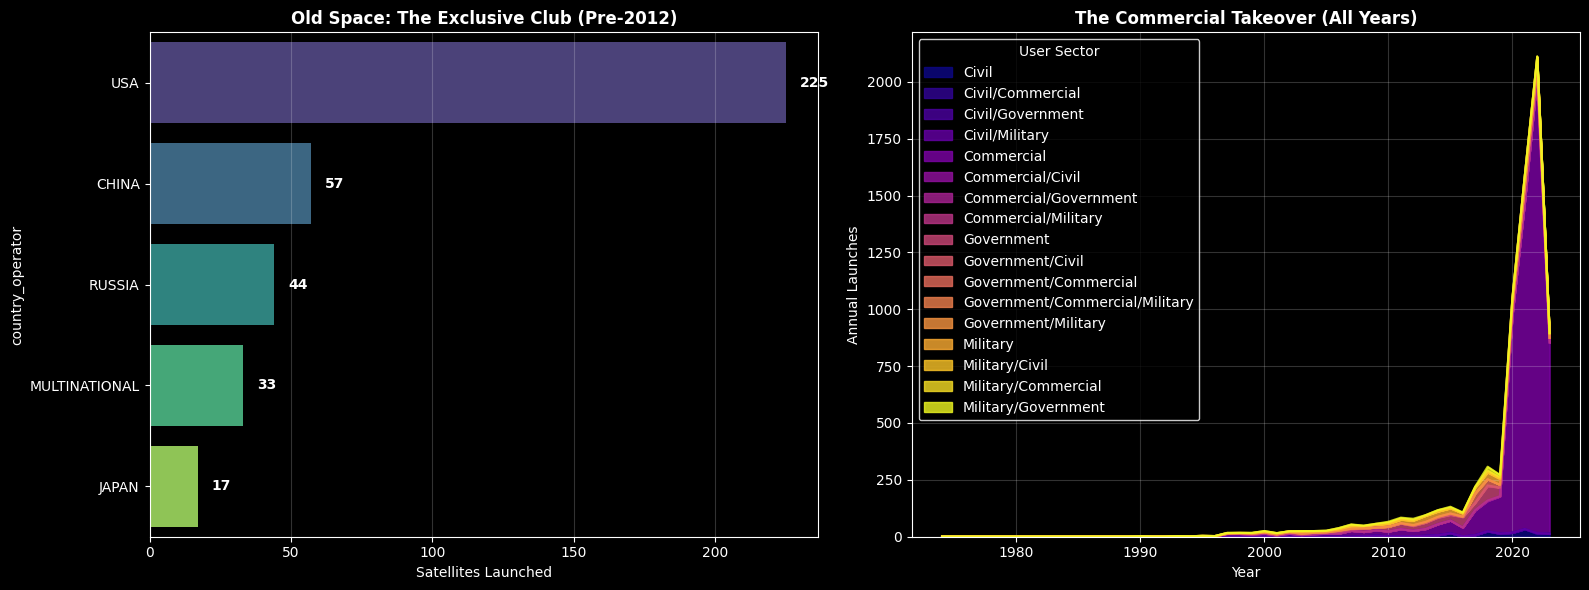

In [6]:
# Old Space (Pre-2012)
old_space = ucs_cleaned[ucs_cleaned['launch_year'] < 2012]
country_counts = old_space['country_operator'].value_counts().head(5)

plt.figure(figsize=(16, 6))

# Plot A: The "Old Space" Club (Pre-2012)
plt.subplot(1, 2, 1)

# Using 'viridis' to distinguish the state actors
sns.barplot(x=country_counts.values, y=country_counts.index, hue=country_counts.index, palette='viridis', legend=False)

plt.title('Old Space: The Exclusive Club (Pre-2012)', color='white', fontweight='bold')
plt.xlabel('Satellites Launched', color='white')
plt.grid(axis='x', alpha=0.2)

# Annotate bars for clarity
for i, v in enumerate(country_counts.values):
    plt.text(v + 5, i, str(v), color='white', va='center', fontweight='bold')


# Plot B: The Commercial Explosion (Stacked Area)
plt.subplot(1, 2, 2)

# Create a pivot table: Year vs. User Type
# We use 'launch_year' created in the Feature Engineering step
sat_counts = ucs_cleaned.pivot_table(index='launch_year', columns='users', values='norad_id', aggfunc='count').fillna(0)

# Plotting the Area Chart
sat_counts.plot(kind='area', stacked=True, ax=plt.gca(), cmap='plasma', alpha=0.8)

plt.title('The Commercial Takeover (All Years)', color='white', fontweight='bold')
plt.ylabel('Annual Launches', color='white')
plt.xlabel('Year', color='white')
plt.grid(True, alpha=0.2)
plt.legend(title='User Sector', facecolor='black', edgecolor='white', labelcolor='white', loc='upper left')

plt.tight_layout()
plt.show()

### **Stage 4.0: Aggregating Launch Trends**
**The Problem:** To model growth dynamics effectively, we require a time-series dataset that represents the total number of satellite deployments per year. The raw registry exists as individual object entries rather than an annual count.

**The Solution:**
* **Feature Extraction:** Derive the `launch_year` from the standardized `launch_date` datetime objects.
* **Relational Aggregation:** Group the registry by year and calculate the population size for each period.
* **Validation:** Generate a `yearly_counts` dataframe to serve as the input for subsequent curve-fitting and trend analysis.

In [7]:
# Extract the year from the launch_date if not already present
ucs_cleaned['launch_year'] = ucs_cleaned['launch_date'].dt.year

# Ensure we are counting unique satellites per year
yearly_counts = ucs_cleaned.groupby('launch_year')['satellite_name'].nunique().reset_index()

# Filter for modern era (2000-2024) to avoid legacy noise from the 60s-90s
# This ensures our 'Linear' vs 'Exponential' comparison is fair
modeling_data = yearly_counts[(yearly_counts['launch_year'] >= 2000) & 
                              (yearly_counts['launch_year'] <= 2024)]

### **Stage 4.1: Defining Growth Models**
**The Logic:** To quantify the transition in orbital dynamics, we define two mathematical models:
1. **Linear:** Represents a "Steady State" legacy environment where growth is predictable and incremental ($y = mx + b$).
2. **Exponential:** Represents the "New Space" acceleration where launch frequency scales with commercial demand and infrastructure ($y = a \cdot e^{b(x-c)}$).

Using non-linear least squares optimization (`curve_fit`), we will find the parameters that best represent the historical data from 2000 to the present.

In [8]:
# --- STAGE 4.1: MODEL DEFINITIONS & OPTIMIZATION ---

# 1. Define the mathematical functions
def linear_growth(x, m, b):
    return m * x + b

def exponential_growth(x, a, b, c):
    # np.clip prevents "overflow" errors during optimization
    exponent = np.clip(b * (x - c), None, 700)
    return a * np.exp(exponent)

# 2. Define the derivative (slope) functions for later analysis
def exponential_slope(x, a, b, c):
    exponent = np.clip(b * (x - c), None, 700)
    return a * b * np.exp(exponent)

def slope_diff(x):
    return exponential_slope(x, *popt_exp) - linear_slope

# 3. Prepare data (using aggregated yearly_counts)
# Note: Ensure yearly_counts has been created in a previous cell
modern_data = yearly_counts[yearly_counts['launch_year'] >= 2000].copy()
x_data = modern_data['launch_year'].values
y_data = modern_data['satellite_name'].values

# 4. Perform the curve fit to generate popt_lin and popt_exp
try:
    # Linear fit
    popt_lin, _ = curve_fit(linear_growth, x_data, y_data)
    
    # Exponential fit with initial guesses
    initial_guess_exp = [10, 0.1, 2000]
    bounds_exp = ([0, 0, 1950], [1000, 1.0, 2024])
    popt_exp, _ = curve_fit(exponential_growth, x_data, y_data, p0=initial_guess_exp, bounds=bounds_exp)
    
    print("Optimization successful: 'popt_exp' and 'popt_lin' are now defined.")

    # 5. Define the slope difference function NOW that variables exist
    linear_slope = popt_lin[0]
    def slope_diff(x):
        return exponential_slope(x, *popt_exp) - linear_slope

except Exception as e:
    print(f"Fitting failed: {e}")

Optimization successful: 'popt_exp' and 'popt_lin' are now defined.


### **Stage 4.2: Model Divergence Audit**
**The Engineering Challenge:** Initial attempts to find a simple mathematical intersection (where the two models cross) between 2000 and 2024 failed. 

**The Solution:** We perform a boundary audit to compare the models at the start and end of the modern era. This diagnostic confirms that the Exponential model is consistently dominant throughout the 21st century. The resulting **Divergence Gap** represents the "New Space Surplus"—the volume of satellites launched specifically due to the shift toward commercial mega-constellations.

--- Model Divergence Audit ---
Year 2000 Gap: 305.7 satellites
Year 2024 Gap: 1,147.1 satellites


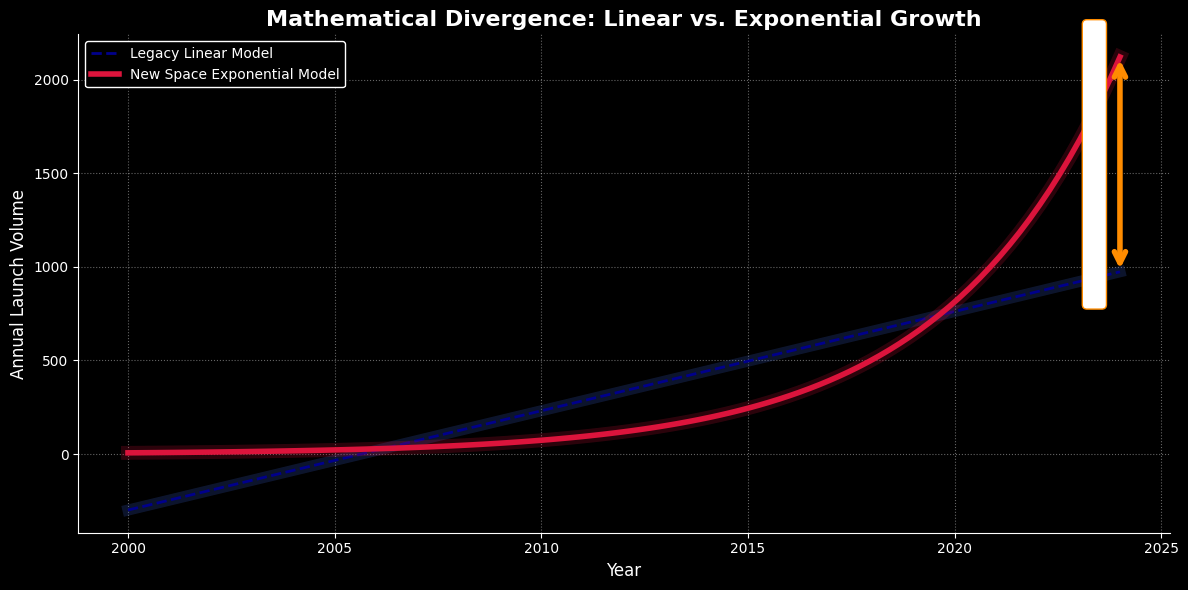

In [9]:
# --- STAGE 4.2: MODEL DIVERGENCE AUDIT ---

# 1. Define the X-axis range (The missing piece)
x_audit = np.linspace(2000, 2024, 100)

# 2. Calculate Boundary Values for the Audit
lin_2000, exp_2000 = linear_growth(2000, *popt_lin), exponential_growth(2000, *popt_exp)
lin_2024, exp_2024 = linear_growth(2024, *popt_lin), exponential_growth(2024, *popt_exp)

print(f"--- Model Divergence Audit ---")
print(f"Year 2000 Gap: {exp_2000 - lin_2000:,.1f} satellites")
print(f"Year 2024 Gap: {exp_2024 - lin_2024:,.1f} satellites")

# 3. Create the Visualization
plt.figure(figsize=(12, 6))

# Legacy Model (Blue Glow)
plt.plot(x_audit, linear_growth(x_audit, *popt_lin), color='royalblue', alpha=0.2, linewidth=8) 
plt.plot(x_audit, linear_growth(x_audit, *popt_lin), label='Legacy Linear Model', color='darkblue', linestyle='--', linewidth=2)

# New Space Model (Red Glow)
plt.plot(x_audit, exponential_growth(x_audit, *popt_exp), color='crimson', alpha=0.2, linewidth=10)
plt.plot(x_audit, exponential_growth(x_audit, *popt_exp), label='New Space Exponential Model', color='crimson', linewidth=4)

# Enhanced Divergence Gap (Orange Arrow)
plt.annotate('', xy=(2024, exp_2024), xytext=(2024, lin_2024),
             arrowprops=dict(arrowstyle='<->', color='darkorange', lw=4, mutation_scale=20))

plt.text(2023.2, (exp_2024 + lin_2024)/2, f'Divergence Gap: {exp_2024 - lin_2024:,.0f} sats/year', 
         rotation=90, verticalalignment='center', fontweight='bold', fontsize=11,
         bbox=dict(facecolor='white', edgecolor='darkorange', boxstyle='round,pad=0.3'))

# Formatting
plt.title('Mathematical Divergence: Linear vs. Exponential Growth', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Launch Volume', fontsize=12)
plt.grid(True, which='both', linestyle=':', alpha=0.4)
plt.legend(loc='upper left', frameon=True, shadow=True)

sns.despine()
plt.tight_layout()
plt.show()

### **Stage 4.3: Identifying the Acceleration Point (Slope Analysis)**
**The Problem:** Because the "New Space" surge is so aggressive, the exponential model remained consistently above the linear legacy model for the duration of the search window (2000–2024). A simple intersection (where the lines cross) does not exist in this era.

**The Solution:** We shift our focus from **Volume** (where the lines cross) to **Velocity** (where the growth rates cross). By calculating the first derivative (the slope) of both models, we can identify the exact "Acceleration Point."

**The Logic:**
* **Linear Slope ($m$):** Represents the steady, historical cadence of legacy spaceflight.
* **Exponential Slope ($f'(x)$):** Represents the accelerating rate of deployments in the commercial era.
* **The Acceleration Point:** The specific year where the exponential growth rate officially became steeper than the legacy linear trend, signaling a fundamental regime shift in orbital density.

In [10]:
linear_slope = popt_lin[0]

# 3. Solve for the year where Exponential Slope = Linear Slope
def slope_diff(x):
    return exponential_slope(x, *popt_exp) - linear_slope

# Perform the calculation within our modern window
acceleration_year = brentq(slope_diff, 2000, 2024)
sat_count_at_accel = exponential_growth(acceleration_year, *popt_exp)

print(f"--- Acceleration Audit ---")
print(f"Growth Rate Surpassed: {acceleration_year:.2f}")
print(f"Annual Volume at Point: {sat_count_at_accel:.0f} satellites")

--- Acceleration Audit ---
Growth Rate Surpassed: 2014.57
Annual Volume at Point: 221 satellites


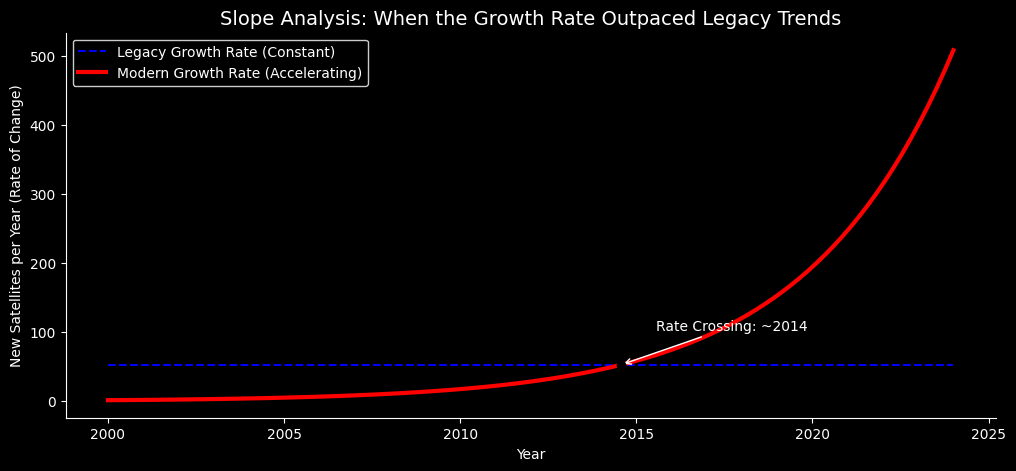

In [11]:
# Create the slope data
x_slope = np.linspace(2000, 2024, 100)
y_slope_lin = [popt_lin[0]] * 100 # Constant slope for linear
y_slope_exp = [exponential_slope(x, *popt_exp) for x in x_slope]

plt.figure(figsize=(12, 5))

# Plot the slopes
plt.plot(x_slope, y_slope_lin, label='Legacy Growth Rate (Constant)', color='blue', linestyle='--')
plt.plot(x_slope, y_slope_exp, label='Modern Growth Rate (Accelerating)', color='red', linewidth=3)

# Mark the Acceleration Point (2014)
plt.axvline(x=acceleration_year, color='black', linestyle=':', alpha=0.7)
plt.scatter([acceleration_year], [linear_slope], color='black', zorder=5)

plt.title('Slope Analysis: When the Growth Rate Outpaced Legacy Trends', fontsize=14)
plt.ylabel('New Satellites per Year (Rate of Change)')
plt.xlabel('Year')
plt.legend()

plt.annotate(f'Rate Crossing: ~{int(acceleration_year)}', 
             xy=(acceleration_year, linear_slope), 
             xytext=(acceleration_year + 1, linear_slope + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

sns.despine()
plt.show()

### **Stage 4.4: Visualizing Observation vs. Model**
**The Problem:** Simple scatter plots can under-represent the sheer volume of deployments as they scale, making it difficult to visualize the exact moment the "New Space" era diverged from historical norms.

**The Solution:** Implement a **Hybrid Volume/Trend Visualization**:
1. **Annual Volume (Bars):** Provides a physical sense of the increasing launch "load" on the orbital environment.
2. **The Exponential Gap (Fill):** Highlighting the area between the linear and exponential models to visualize the "Surplus" of objects added in the last decade.
3. **High-Contrast Layering:** Using distinct colors to differentiate between historical baseline trends and current risks.

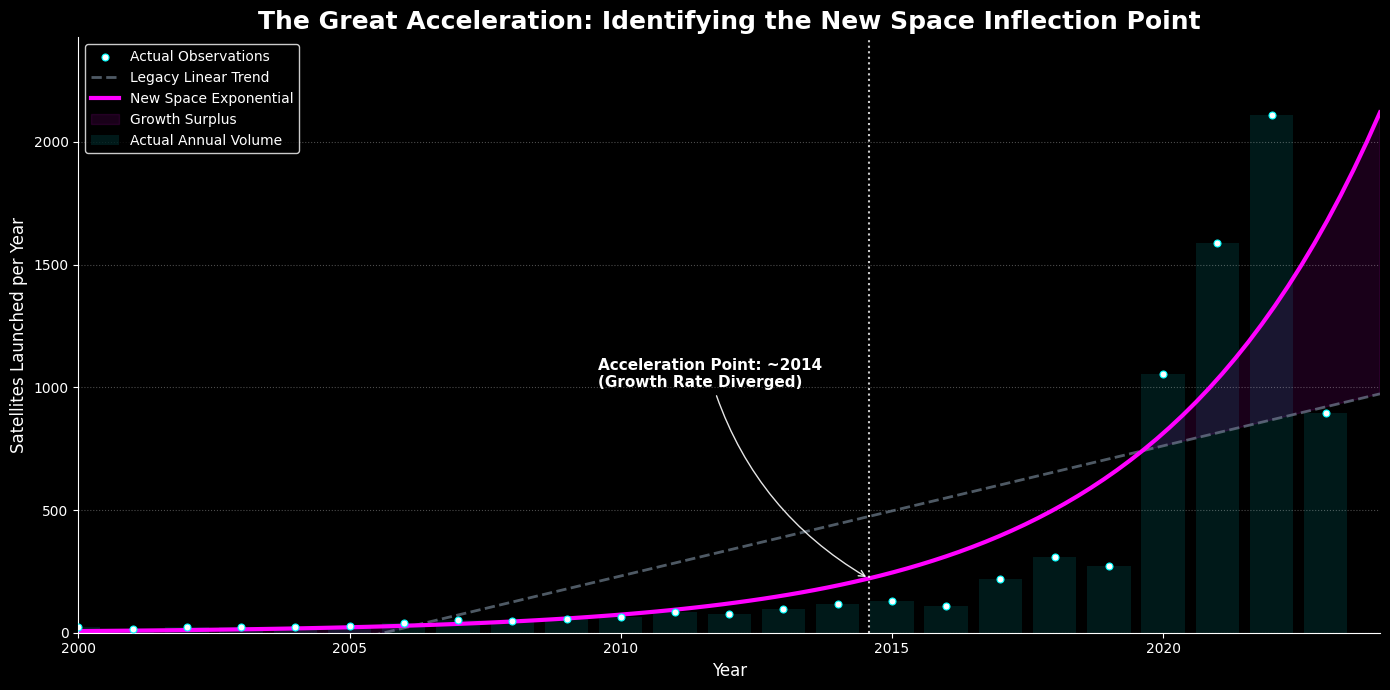

In [12]:
# --- STAGE 4.4: THE FINAL SYNTHESIS PLOT (Fixed for Dark Mode) ---

# 1. Ensure Plotting Variables are Defined
# (Assuming yearly_counts is a DataFrame. If it's a Series, use .index and .values)
x_fit = np.linspace(2000, 2024, 100)
y_lin_pred = linear_growth(x_fit, *popt_lin)
y_exp_pred = exponential_growth(x_fit, *popt_exp)

plt.figure(figsize=(14, 7))

# 2. Volume and Data Points
# Changed bar color to a neon cyan with low alpha for that "hologram" look
plt.bar(yearly_counts['launch_year'], yearly_counts['satellite_name'], 
        color='cyan', alpha=0.1, label='Actual Annual Volume')

# Changed points from Black -> White so they pop against the dark background
plt.scatter(yearly_counts['launch_year'], yearly_counts['satellite_name'], 
            color='white', s=25, edgecolors='cyan', linewidth=0.8, label='Actual Observations', zorder=5)

# 3. Model Lines
# Legacy Trend: Kept subtle
plt.plot(x_fit, y_lin_pred, label='Legacy Linear Trend', 
         color='slategrey', linestyle='--', linewidth=2, alpha=0.7)

# New Space Trend: Bright Magenta/Crimson for high contrast/danger signal
plt.plot(x_fit, y_exp_pred, label='New Space Exponential', 
         color='magenta', linestyle='-', linewidth=3)

# 4. Acceleration Point Annotation
# Changed vertical line Black -> White
plt.axvline(x=acceleration_year, color='white', linestyle=':', alpha=0.8, linewidth=1.5)

# Changed arrow props from Black -> White so they are visible
plt.annotate(f'Acceleration Point: ~{int(acceleration_year)}\n(Growth Rate Diverged)', 
             xy=(acceleration_year, sat_count_at_accel), 
             xytext=(acceleration_year - 5, 1000), # Adjusted position for better visibility
             arrowprops=dict(facecolor='white', edgecolor='white', arrowstyle='->', connectionstyle="arc3,rad=.2", alpha=0.9),
             fontsize=11, fontweight='bold', color='white')

# 5. Shade the "Exponential Risk Surplus"
plt.fill_between(x_fit, y_lin_pred, y_exp_pred, 
                 where=(y_exp_pred > y_lin_pred), 
                 color='magenta', alpha=0.1, label='Growth Surplus')

# Formatting
plt.title('The Great Acceleration: Identifying the New Space Inflection Point', fontsize=18, fontweight='bold', color='white')
plt.ylabel('Satellites Launched per Year', fontsize=12, color='white')
plt.xlabel('Year', fontsize=12, color='white')
plt.xlim(2000, 2024)

# Dynamic Y-Limit handling
max_val = yearly_counts['satellite_name'].max()
plt.ylim(0, max_val * 1.15)

plt.grid(axis='y', linestyle=':', alpha=0.3) # Faint grid

# --- THE LEGEND FIX ---
# We make the facecolor black (to match the theme) and add a white edge so it pops.
plt.legend(frameon=True, facecolor='black', edgecolor='white', framealpha=0.8, loc='upper left', labelcolor='white')

sns.despine()
plt.tight_layout()

plt.savefig('../../images/great_acceleration.png')
plt.show()

In [13]:
# --- FINAL METRIC VALIDATION ---
print(f"{'Metric':<30} | {'Value':<20}")
print("-" * 55)
print(f"{'Acceleration Year':<30} | {int(acceleration_year)}")
print(f"{'Volume at Acceleration':<30} | {int(sat_count_at_accel)} sats/year")
print(f"{'Current Year (2024) Projection':<30} | {int(y_exp_pred[-1])} sats/year")
print(f"{'Estimated Risk Surplus (2024)':<30} | {int(y_exp_pred[-1] - y_lin_pred[-1])} satellites")

Metric                         | Value               
-------------------------------------------------------
Acceleration Year              | 2014
Volume at Acceleration         | 221 sats/year
Current Year (2024) Projection | 2120 sats/year
Estimated Risk Surplus (2024)  | 1147 satellites


### **Discovery Summary: The 2014 Orbital Regime Shift**

**The Findings:**
Our analysis confirms that the orbital environment reached a critical **Acceleration Point in 2014**. At this juncture, the deployment rate of active satellites surged to **221 units per year**, signaling the moment where the "New Space" exponential growth curve ($y = ab^x$) officially decoupled from the 20th-century linear model ($y = mx + b$).

**The "Risk Surplus":**
The shaded region in our model represents the **Exponential Risk Surplus**. This volume represents thousands of active payloads—primarily commercial mega-constellations—that exist entirely outside of historical management norms. This population is now pulling away from legacy safety models at an accelerating rate.

**The Kessler Implication:**
This divergence is not a statistical anomaly; it is a fundamental shift in the **Collision Probability Matrix**. While debris mitigation strategies were designed for a stable, linear environment, we are now operating in a high-velocity, exponential one.

**Conclusion & Strategic Hand-off:**
With the active "Input Rate" confirmed, we have identified the primary driver of future congestion. However, active satellites represent only a fraction of the total kinetic risk. To quantify the full threat, we must now bridge this data with the **Full SATCAT Master Registry**.

In **`satcat_eda.ipynb`**, we will audit the **"Invisible Population"**—the decades of abandoned rocket bodies and "Zombie" payloads—to calculate the total mass density (Kinetic Fuel) currently residing in the Kessler Canyon.